# Load Data and Import Libraries

In [3]:
# Using training data from Udacity car simulator -- data already gathered and published on Github
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 17.38 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [4]:
# Library Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

# Data Visualization

In [5]:
# Reading Data
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', 0) # Allows you to see entire content in each column
data.head()

center  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg   

                                                                   left  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg   

                                                                   right  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.649786  
1  0.0       0.0       0.0      0.627942  
2  0.0       0.0       0.0      0.622910  
3  0.0       0.0       0.0      0.619162  
4  0.0       0.0       0.0      0.615438

In [6]:
#Remove junk portion of image paths
def tail_only(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(tail_only)
data['left'] = data['left'].apply(tail_only)
data['right'] = data['right'].apply(tail_only)
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg  0.0       0.0       0.0      0.649786  
1  right_2018_07_16_17_11_43_670.jpg  0.0       0.0       0.0      0.627942  
2  right_2018_07_16_17_11_43_724.jpg  0.0       0.0       0.0      0.622910  
3  right_2018_07_16_17_11_43_792.jpg  0.0       0.0       0.0      0.619162  
4  right_2018_07_16_17_11_43_860.jpg  0.0       0.0       0.0      0.615438

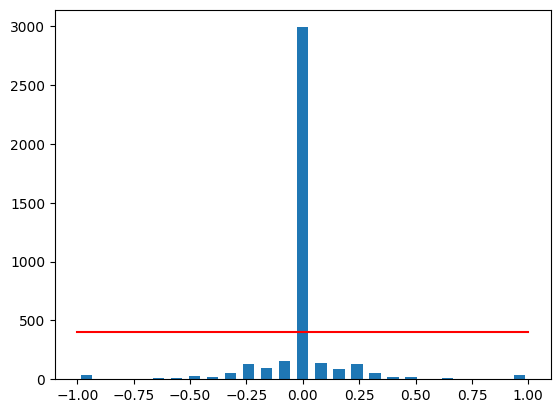

In [7]:
# View distribution of steering angle: negative is left, positive is right
num_bins = 25 #range of steering angles divided into 25
hist, bins = np.histogram(data['steering'], num_bins) #hist contains counts of steering angle values in each bin, bins contains the bin edges
center = (bins[:-1] + bins[1:]) / 2 #Calculates center of each bin by averaging left and right boundaries/edges
plt.bar(center, hist, width=0.05) #Creates histogram
plt.plot((np.min(data['steering']), np.max(data['steering'])), (400,400), 'r') #Plots line that spans full x-axis and at y=400

In [8]:
print('rows (number of distinct points along car drive):', data.shape[0])
print('cols (parameters being measured):', data.shape[1])

rows (number of distinct points along car drive): 4053
cols (parameters being measured): 7


# Data Balancing

In [9]:
# Too many zeroes will bias the model; in this data only 0.0 has more than 400 instances, but in other datasets other angles can have >400
# instances, hence the implementation below. For this specific data it is not necessary but used nonetheless.

remove_list = []
for j in range(num_bins):
  list_bin = [] #stores indices of rows that fall within the current bin's range.
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_bin.append(i)
  list_bin = shuffle(list_bin) #list_bin is shuffled to randomize order
  list_bin = list_bin[400:] #Only keep indices starting from the 401st index onward; if len(list_bin) < 400, list_bin is empty
  remove_list.extend(list_bin) #list_bin is added to the end of remove_list

print('removed:', len(remove_list))

#Rows whose indices are in remove_list are removed from the DataFrame data; inplace=True ensures removal is done directly on original DataFrame.
data.drop(data.index[remove_list], inplace=True)

print('remaining:', len(data))

removed: 2590
remaining: 1463


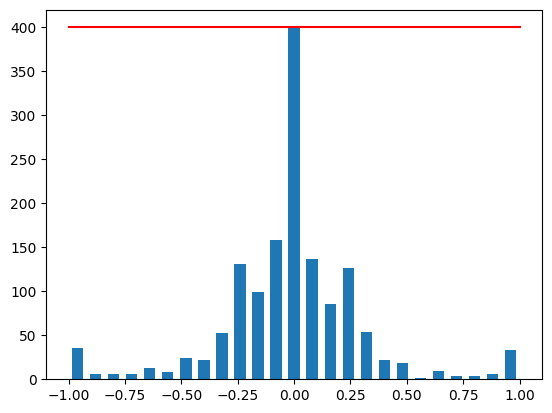

In [10]:
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (400, 400), 'r')

# Training and Validation Split

In [11]:
#Just visualizing data for comprehension
print(len(data), datadir, "\n")
temp = data.iloc[0]
print(temp)

1463 track 

center      center_2018_07_16_17_11_44_342.jpg
left        left_2018_07_16_17_11_44_342.jpg  
right       right_2018_07_16_17_11_44_342.jpg 
steering    0.0                               
throttle    0.382694                          
reverse     0.0                               
speed       0.946799                          
Name: 11, dtype: object


In [12]:
#Function to convert images to numpy arrays and pair with steering angles, steering angles also converted to array

def load_image_steering(datadir, df):
  image_paths = []
  steerings = []
  for i in range (len(df)):
    event = df.iloc[i] #Gets each row
    center, left, right = event[0], event[1], event[2]
    #Center image append
    image_paths.append(os.path.join(datadir, center.strip()))
    steerings.append(float(event[3])) #Use float value for consistency and because angle is being read from CSV file
    #Left image append
    image_paths.append(os.path.join(datadir, left.strip()))
    steerings.append(float(event[3]) + 0.15) #Need to adjust steering angle so that car knows to remain in the center of the lane
    #Right image append
    image_paths.append(os.path.join(datadir, right.strip()))
    steerings.append(float(event[3]) - 0.15) #Need to adjust steering angle so that car knows to remain in the center of the lane
  image_paths = np.array(image_paths)
  steerings = np.array(steerings)
  return image_paths, steerings

In [13]:
images, steering_angles = load_image_steering(datadir + '/IMG', data)

In [14]:
print(len(images))
print(len(steering_angles))

4389
4389


In [15]:
#Training and Validation split

X_train, X_valid, y_train, y_valid = train_test_split(images, steering_angles, test_size=0.2, random_state=6)
print('Training Samples:', len(X_train))
print('Validation Samples:', len(X_valid))

Training Samples: 3511
Validation Samples: 878


Text(0.5, 1.0, 'Validation set')

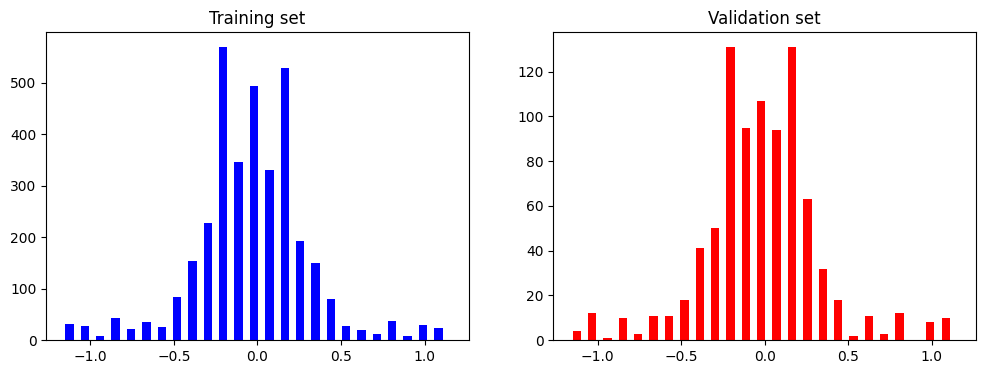

In [16]:
#Visualize training and validation data distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

# Data Augmentation

Boost robustness of the model by adding variability to data

Techniques:

*   Zoom
*   Pan (Translation)
*   Random Brightness
*   Flip




Text(0.5, 1.0, 'Zoomed Image')

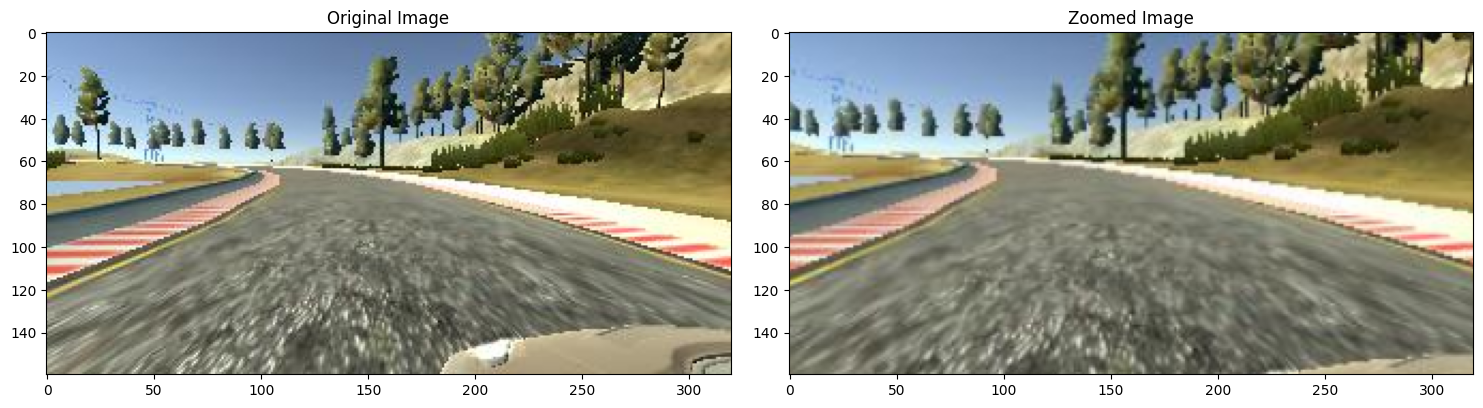

In [17]:
#Zoom function
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

#Test zoom function on random image from images array
image = images[random.randint(0, len(images) - 1)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

#Plot images
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout() # Automatically adjusts subplot parameters to fit within the figure area

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

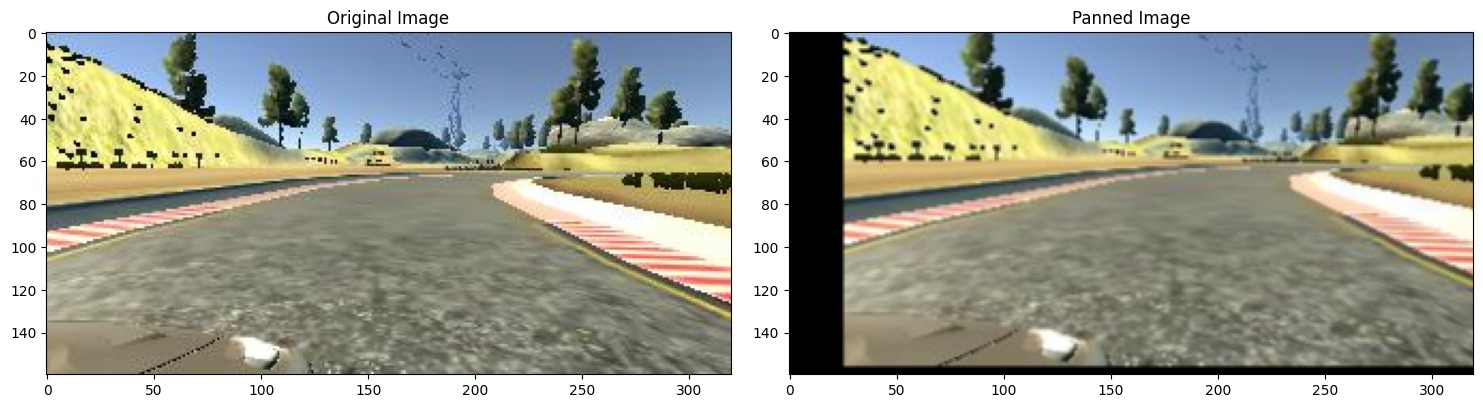

In [18]:
#Pan function
def pan(image):
  pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}) #Image can be translated horizontally and vertically up to -10% and 10% of its width
  image = pan.augment_image(image)
  return image

#Test pan function on random image from images array
image = images[random.randint(0, len(images) - 1)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

#Plot images
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness Altered Image')

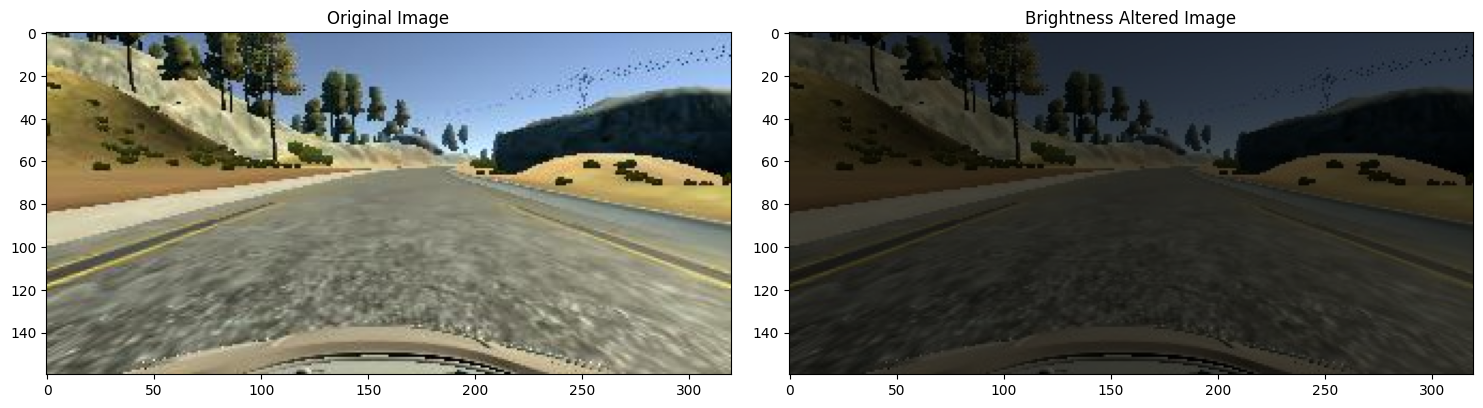

In [19]:
#Random image brightness function
def image_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2)) #Value between 0.2 and 1.2
  image = brightness.augment_image(image)
  return image

#Test image brightness function on random image from images array
image = images[random.randint(0, len(images) - 1)]
original_image = mpimg.imread(image)
brightness_altered_image = image_random_brightness(original_image)

#Plot images
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

Text(0.5, 1.0, 'Flipped Image; Steering Angle: -0.7000001')

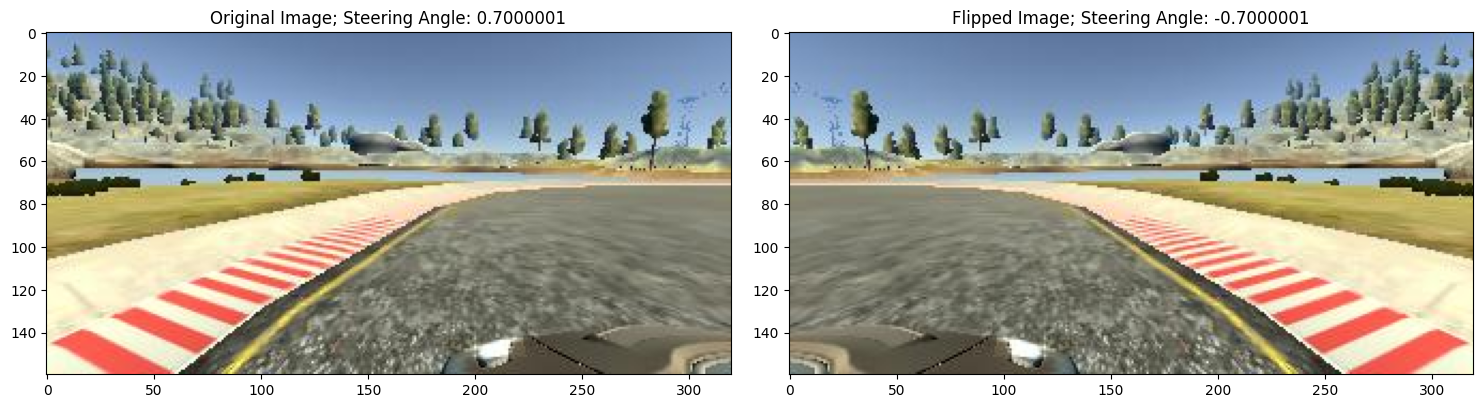

In [20]:
#Flip function
def flip(image, steering_angle):
  image = cv2.flip(image, 1) #Flips image along vertical axis; use 0 to flip image across horizontal axis
  steering_angle = -steering_angle
  return image, steering_angle

#Test flip function on random image from images array
random_index = random.randint(0, len(images) - 1)
image = images[random_index]
steering_angle = steering_angles[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = flip(original_image, steering_angle)

#Plot images
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image; ' + 'Steering Angle: ' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image; ' + 'Steering Angle: ' + str(flipped_steering_angle))

In [21]:
#Combine all data augmentation techniques using randomization
def random_augment(image, steering_angle):
  image = mpimg.imread(image)

  if np.random.rand() < 0.5: #Generates a single random float in the range [0, 1)
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = image_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = flip(image, steering_angle)

  return image, steering_angle

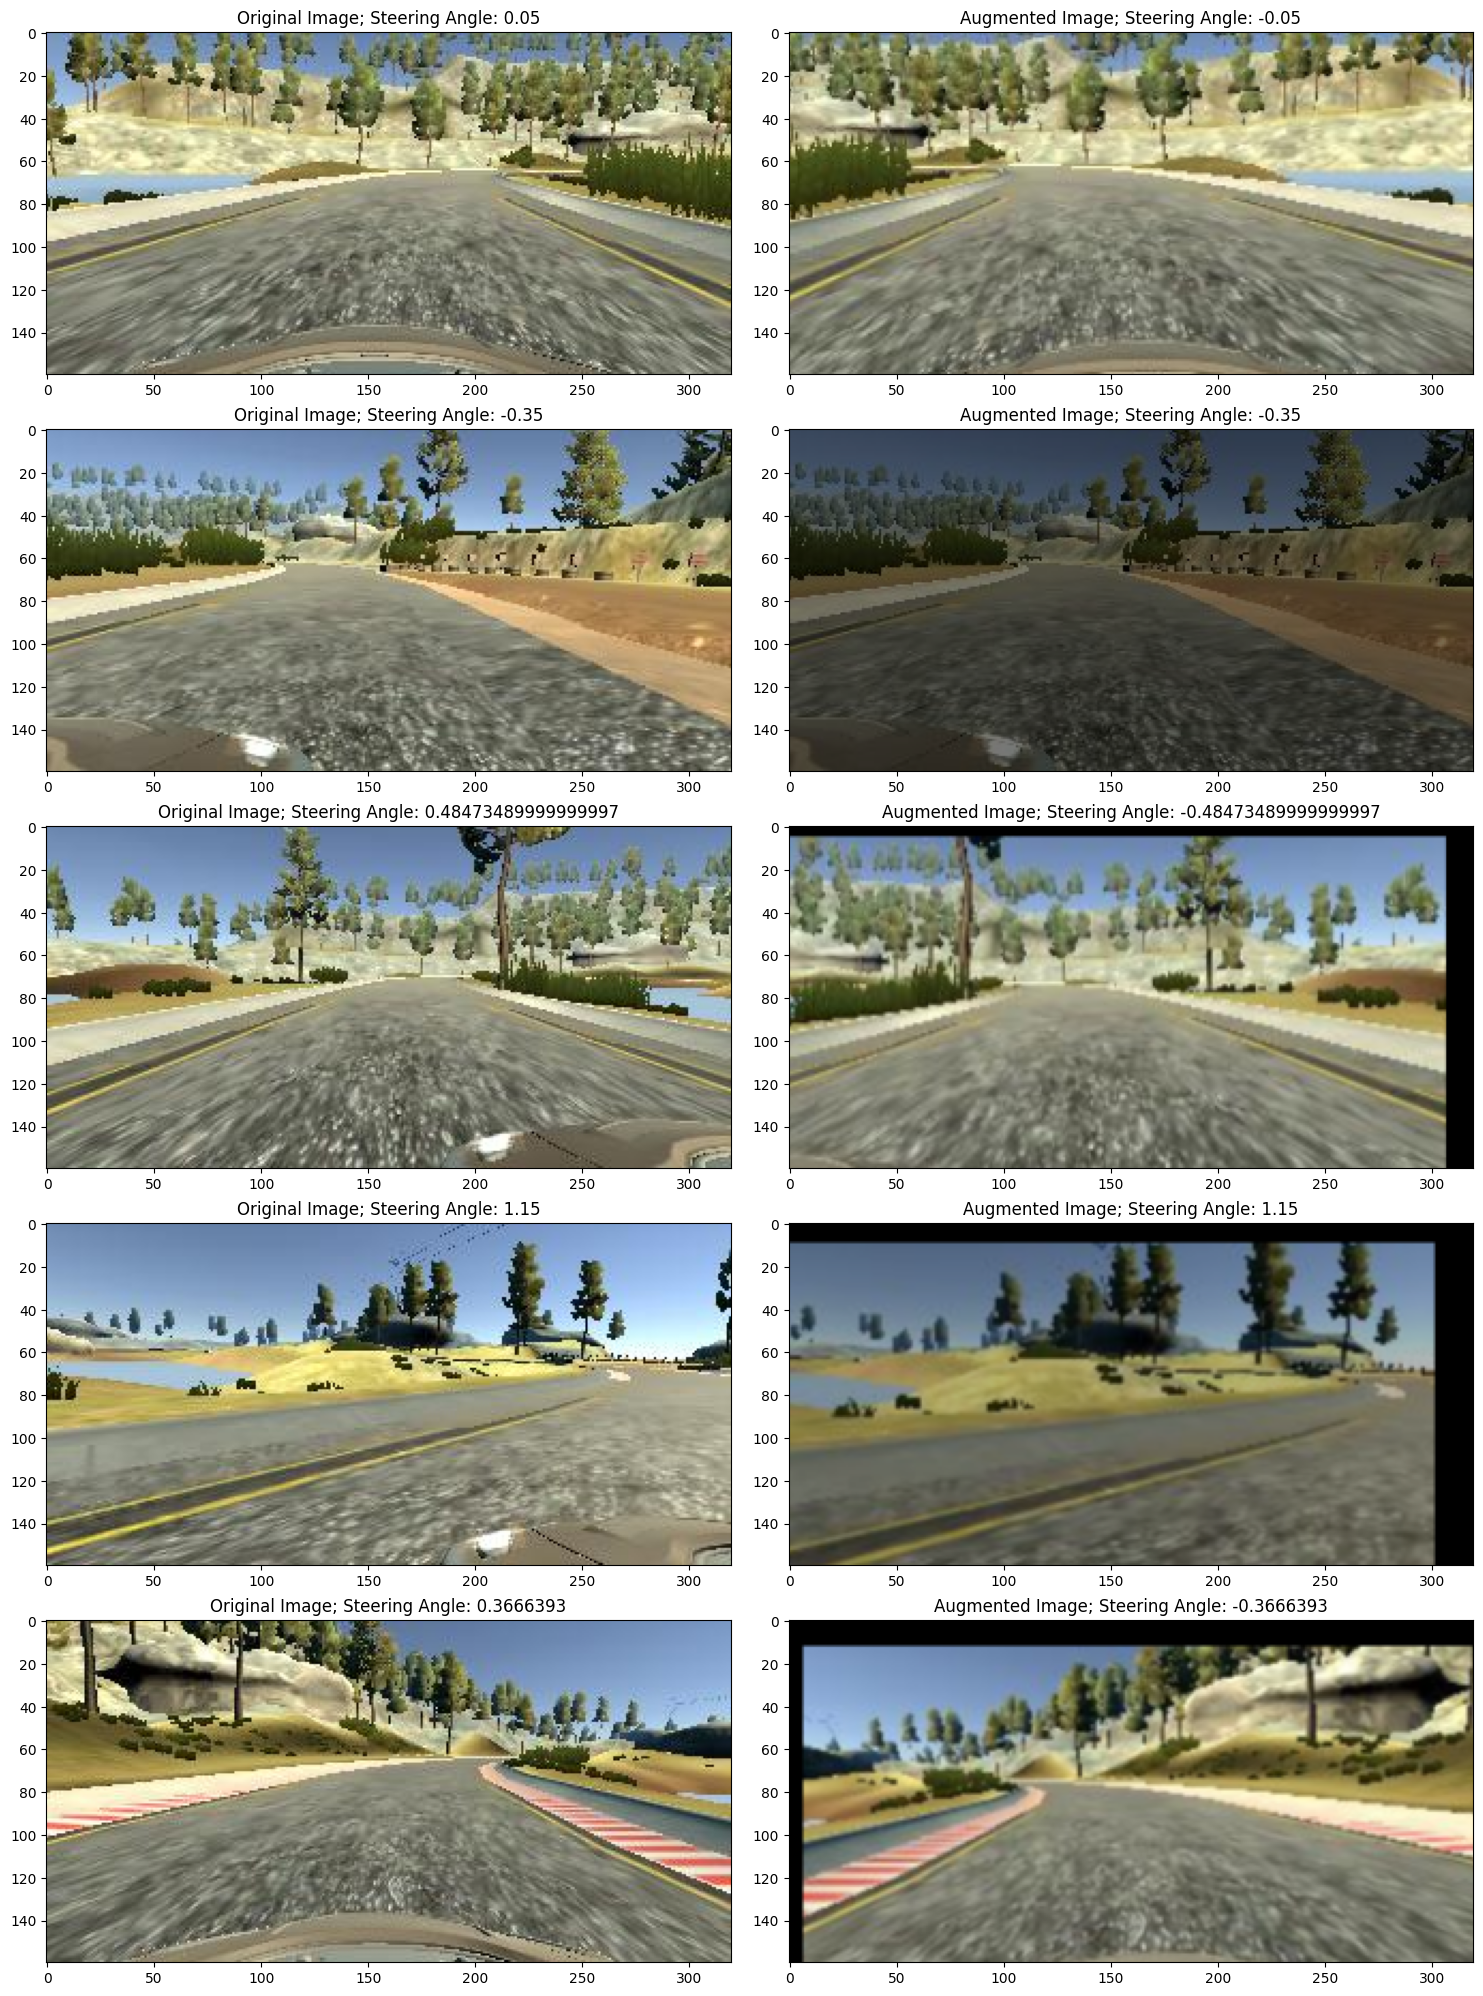

In [22]:
#Visualize random_augment function

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
fig.tight_layout()

for i in range(5):
  random_index = random.randint(0, len(images) - 1)
  random_image = images[random_index]
  random_steering = steering_angles[random_index]

  original_image = mpimg.imread(random_image)
  augmented_image, augmented_steering = random_augment(random_image, random_steering)

  axs[i, 0].imshow(original_image)
  axs[i, 0].set_title('Original Image; ' + 'Steering Angle: ' + str(random_steering))

  axs[i, 1].imshow(augmented_image)
  axs[i, 1].set_title('Augmented Image; ' + 'Steering Angle: ' + str(augmented_steering))

# Image Preprocessing

Remove as much of background as possible to eliminate image complexity for the model and keep convolutional focus on the road

In [23]:
def image_preprocess(image):
  image = image[60:135, :, :] #Three parameters are row, col, channels (color). This leaves col and channel the same, and crops row between index 60 and 135.
  image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV) #Converts from RGB to YUV, which is necessary for the model we will use
  image = cv2.GaussianBlur(image, (3, 3), 0) #Gaussian blur with 3x3 kernel
  image = cv2.resize(image, (200, 66)) #Resize images for standardization
  image = image/255 #Normalize pixel values to the range [0, 1]
  return image

Text(0.5, 1.0, 'Preprocessed Image')

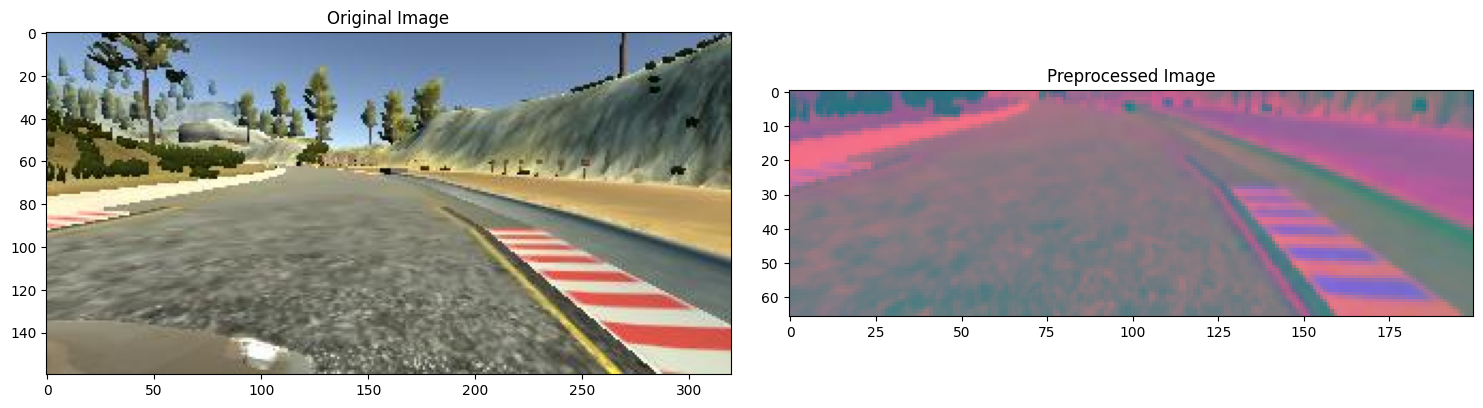

In [24]:
image = images[random.randint(0, len(images) - 1)]
orignial_image = mpimg.imread(image)
preprocessed_image = image_preprocess(orignial_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(orignial_image)
axs[0].set_title('Original Image')

axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

# Batch Generator

Need to seperate data into batches when feeding it to model as sending all data at once can overload the memory

In [25]:
#Commands to check GPU configuration when using colab's free GPU
!nvidia-smi
!nvidia-smi -L #Shorthand version

/bin/bash: line 1: nvidia-smi: command not found
/bin/bash: line 1: nvidia-smi: command not found


In [26]:
#Batch Generator Function
def batch_generator(images, steering_angles, batch_size, isTraining):
  #Infinite loop ensures the generator can continuously provide data as long as the training loop requires
  while True:
    batch_images = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(images) - 1)

      if isTraining: #Only apply augmentation on training data, not on validation or testing data
        im, steering = random_augment(images[random_index], steering_angles[random_index])
      else:
        im, steering = mpimg.imread(images[random_index]), steering_angles[random_index]

      im = image_preprocess(im)
      batch_images.append(im)
      batch_steering.append(steering)
    #Yield converts the function into a generator, allowing it to produce data one batch at a time, which more efficient for memory and processing
    yield (np.asarray(batch_images), np.asarray(batch_steering))

In [27]:
#Printing data types to deal with error
print(type(images))
print(type(images[0]))
print(type(mpimg.imread(images[0])))

<class 'numpy.ndarray'>
<class 'numpy.str_'>
<class 'numpy.ndarray'>


Text(0.5, 1.0, 'Validation Image')

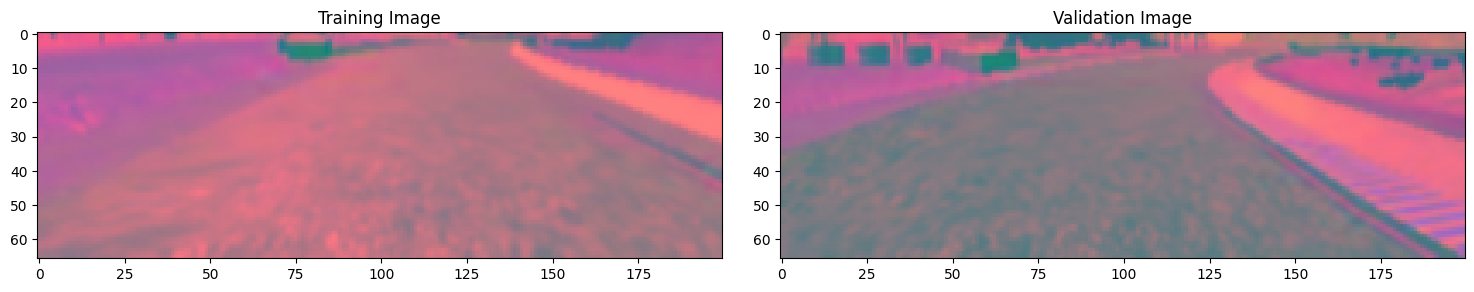

In [28]:
#Testing batch generator with a batch size of one image
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, True))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, False))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

# CNN Machine Learning Model

*   NVIDIA released a CNN machine learning model architecture for end to end learning for self-driving cars, so we will be using a modified version of NVIDIA's architecture
*   Link to NVIDIA Paper: https://arxiv.org/pdf/1604.07316
*   Model architecture is on page 5



---

Model Details:

*   By decreasing the number of units in dense layers, the network effectively transitions from high-dimensional, detailed representations to low-dimensional, abstract representations, improving generalization and efficiency.
*   Adam Optimizer: Chosen for its efficiency and adaptive learning rate capabilities.
*   Learning Rate of 0.001: Provides a good balance between training speed and stability, often working well as a default setting.
*   MSE Loss: Penalizes larger errors more heavily.





In [29]:
def cnn_model():

  model = Sequential()

  # First convolutional layer:
  # - 24 filters: layer will learn to detect 24 features
  # - Each filter is a 5x5 kernel
  # - Stride of 2x2 means the filter moves 2 pixels at a time both horizontally and vertically across input image
  # - Input shape means the image has a height of 66 pixels, width of 200 pixels, and 3 color channels (RGB)
  # - Activation is ELU instead of ReLU because of the dying ReLU problem, in which neurons can get stuck during training and always output 0
  model.add(Conv2D(24, (5,5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, (5,5), strides=(2,2), activation='elu'))
  # When stride is not specified it is automatically 1x1. In initial layers, larger strides are used to reduce spatial dimensions
  # In deeper layers, using stride of 1x1 allows network to extract detailed features without losing spatial information
  model.add(Conv2D(64, (3,3), activation='elu'))
  model.add(Conv2D(64, (3,3), activation='elu')) #As layers are added, we add more features (24, 36, 48...) to capture more fine tune details

  model.add(Dropout(0.5)) #Dropout layer to prevent overfitting by randomly setting 50% of input units to 0

  #Converts multidimensional output of convolutional layers into a one-dimensional vector, which can be fed to fully connected (dense) layers for further processing
  model.add(Flatten())

  #Dense layers with decreasing number of units

  model.add(Dense(100, activation='elu')) #High-capacity layer for complex features (100 units)
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu')) #Intermediate layer for feature consolidation (50 units)
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu')) #Compact layer for final feature abstraction (10 units)
  model.add(Dropout(0.5))

  model.add(Dense(1)) #Final layer for single output (1 unit)

  optimizer = keras.optimizers.Adam(learning_rate=0.001) #Adam optimizer with learning rate of 0.001
  model.compile(loss='mse', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()]) #Compile with MSE loss

  return model

model = cnn_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

# Model Training

In [30]:
#Check tensorflow version
print(tf.__version__)

2.15.0


In [31]:
history = model.fit(
    batch_generator(X_train, y_train, 100, True), #One batch size is 100
    steps_per_epoch=300, #Number of batches per epoch
    epochs=10,
    validation_data=batch_generator(X_valid, y_valid, 100, False), #One batch size is 100
    validation_steps=200, #Number of batches per epoch
    verbose=1, #Verbosity of training output; 1 means progess bar logging, showing training progress per epoch
    shuffle=True #Data will be shuffled before each epoch
)

# Available metrics after training:
print(history.history.keys())

Epoch 1/10
300/300 [==============================] - 428s 1s/step - loss: 0.1294 - root_mean_squared_error: 0.3598 - val_loss: 0.0735 - val_root_mean_squared_error: 0.2712
Epoch 2/10
300/300 [==============================] - 422s 1s/step - loss: 0.0949 - root_mean_squared_error: 0.3080 - val_loss: 0.0652 - val_root_mean_squared_error: 0.2553
Epoch 3/10
300/300 [==============================] - 404s 1s/step - loss: 0.0885 - root_mean_squared_error: 0.2976 - val_loss: 0.0847 - val_root_mean_squared_error: 0.2910
Epoch 4/10
300/300 [==============================] - 417s 1s/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2380
Epoch 5/10
300/300 [==============================] - 418s 1s/step - loss: 0.0844 - root_mean_squared_error: 0.2905 - val_loss: 0.0591 - val_root_mean_squared_error: 0.2431
Epoch 6/10
300/300 [==============================] - 420s 1s/step - loss: 0.0830 - root_mean_squared_error: 0.2881 - val_loss: 0.0596 

Text(0.5, 0, 'Epoch')

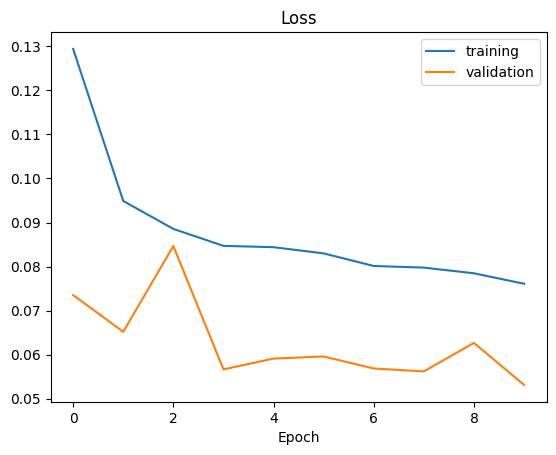

In [33]:
#Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [38]:
#Download model: HDF5 format and native keras format
model.save('model.keras')
model.save('model.h5')
from google.colab import files
files.download('model.keras')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>